Dataset is the Pascal VOC2012 dataset. We focused on class segmentation, no object segmentation.
We created different architectures which are described here.

In [2]:
# Setup constants
input_width = 224
input_height = 224
channels = 3
testing_directory = "VOCdevkit Testing/VOC2012/JPEGImages/"

classes = {
    0: "background",
    1: "aeroplane",
    2: "bicycle",
    3: "bird",
    4: "boat",
    5: "bottle",
    6: "bus",
    7: "car",
    8: "cat",
    9: "chair",
    10: "cow",
    11: "diningtable",
    12: "dog",
    13: "horse",
    14: "motorbike",
    15: "person",
    16: "pottedplant",
    17: "sheep",
    18: "sofa",
    19: "train",
    20: "tvmonitor",
    21: "border"
}

classes = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
           "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant",
           "sheep", "sofa", "train", "tvmonitor", "border"]

custom_colormapping = {
    0: [0, 0, 0],
    1: [128, 0, 0],
    2: [0, 128, 0],
    3: [0, 0, 128],
    4: [0, 128, 128],
    5: [128, 128, 128],
    6: [255, 255, 0],
    7: [0, 255, 0],
    8: [0, 255, 255],
    9: [64, 64, 64],
    10: [128, 255, 255],
    11: [64, 255, 255],
    12: [128, 32, 32],
    13: [32, 32, 32],
    14: [255, 32, 32],
    15: [255, 255, 128],
    16: [40, 255, 128],
    17: [255, 0, 128],
    18: [200, 200, 200],
    19: [0, 200, 200],
    20: [0, 200, 0],
    21: [255, 255, 0]
}

import image_preprocessing as cig
from keras.models import load_model
from keras.models import model_from_json
import json
from PIL import Image
from keras.preprocessing.image import img_to_array
import os

def load_model(model_path):
    print("Loading model...")

    architecture_in_json = os.path.join(model_path, "model.json")
    json_file = open(architecture_in_json, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    weights_in_h5 = os.path.join(model_path, "model.h5")
    loaded_model.load_weights(weights_in_h5)

    print("Loaded model from disk")
    return loaded_model

import numpy as np

def get_test_images(image_names):
    x_test = []
    for image_name in image_names:
        x_image = testing_directory + image_name + ".jpg"
        test_image = cig.get_input(testing_directory, image_name, input_width, input_height)
        x_test.append(test_image)
    return np.array(x_test)
    
def predict_test_images(model, x_test):
    return model.predict(x_test, verbose=1)


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

def get_output_colored(samples_count, output):
    output_colored = np.zeros((samples_count, input_width, input_height, channels))
    for index, _ in np.ndenumerate(output):
        sample = index[0]
        width = index[1]
        height = index[2]
        class_index = output[sample, width, height]
        rgb_array = custom_colormapping[class_index]
        output_colored[sample, width, height, 0] = rgb_array[0]
        output_colored[sample, width, height, 1] = rgb_array[1]
        output_colored[sample, width, height, 2] = rgb_array[2]
    return output_colored

def get_output_and_distributions(samples_count, predicted):
    distributions = np.zeros((samples_count, 22)).astype(int)
    output = np.zeros((samples_count, input_width, input_height))
    for index, _ in np.ndenumerate(output):
        sample = index[0]
        width = index[1]
        height = index[2]
        class_index = np.argmax(predicted[sample, width, height])
        output[sample, width, height] = class_index
        if class_index != 0 and class_index != 21:
            distributions[sample][class_index] += 1
    distributions = distributions / distributions.sum(axis=1, keepdims=True)
    
    return output, distributions

def remove_low_values_from_distributions(distributions, threshold):
    distribution_arr_dict = []
    for distribution in distributions:
        distribution_dict = {}
        for index in range(len(distribution)):
            if distribution[index] > threshold:
                distribution_dict[classes[index]] = distribution[index]
        distribution_arr_dict.append(distribution_dict)
    return distribution_arr_dict

def predict(model):
    images_to_predict = ['2008_000012', '2008_000030', '2008_000081']
    x_test = get_test_images(images_to_predict)
    predicted = predict_test_images(model, x_test)
    samples_count = len(images_to_predict)

    output, distributions = get_output_and_distributions(samples_count, predicted)
    output_colored = get_output_colored(samples_count, output)
    distributions = remove_low_values_from_distributions(distributions, threshold=0.05)

    fig, axs = plt.subplots(samples_count, 4, figsize=(30, 30))

    for i in range(samples_count): 
        axs[i,0].imshow((x_test[i]).astype(np.uint8))
        axs[i,1].imshow((output[i].astype(np.uint8)), cmap="Accent")
        axs[i,2].imshow((output_colored[i].astype(np.uint8)))
        axs[i,3].imshow((x_test[i]).astype(np.uint8))
        axs[i,3].imshow((output[i].astype(np.uint8)), cmap="gray", alpha=0.5)
    fig.tight_layout()

    fig, axs = plt.subplots(1, samples_count, figsize=(20, 5))

    for distribution_index in range(len(distributions)):
        distribution = distributions[distribution_index]
        axs[distribution_index].bar(range(len(distribution)), list(distribution.values()), align='center')
        axs[distribution_index].set_xticks(range(len(distribution)))
        axs[distribution_index].set_xticklabels(list(distribution.keys()))
        
def plot_loss_and_accuracy(model_path):
    fig, axs = plt.subplots(1,2,figsize=(20,10))
    with Image.open(os.path.join(model_path, "training_loss.jpg")) as image:
        loss = img_to_array(image)
    
    with Image.open(os.path.join(model_path, "training_accuracy.jpg")) as image:
        accuracy = img_to_array(image)
    
    axs[0].imshow((loss).astype(np.uint8))
    axs[1].imshow((accuracy).astype(np.uint8))
    fig.tight_layout()
    
    
import os
old_results_path = "old_results"
results_path = "results"

# Description

All models are based on fully convolutional neural networks. That means, the fully connected layers at the end which classified the image are removed. Instead, the architecture is like an encoder-decoder network. The image is first downsampled and afterwards upsampled. For each pixel, we predict the class it belongs to by looking for the highest probability via softmax layer at the end. 

# Parameters we used for every architecture

Some parameters we use for every architecture. These are:
- One Block consists of two convolutional layers and a MaxPooling Layer. Max Pooling is always 2x2.
- As activation function on the convolutional layers, we always used ReLU
- Filter sizes on each block are multiplied x 2. That means if we start with 16 filters on block 1, block 2 has 32, block 3 64 filters, block 4 128 filters etc..
- We used SoftMax at the end to get the highest class probability


# Experiment 1
- Unregularized
- 5 encoding blocks, 5 decoding blocks
- Filters on block 1: 16 --> Filters on block 5: 256
- Optimizer: Adam 
    - Learning rate 0.00001
    - Decay: 0.9
- Loss: Categorical_Crossentropy

Loading model...
Loaded model from disk
3/3 [==============================] - 1s 307ms/step


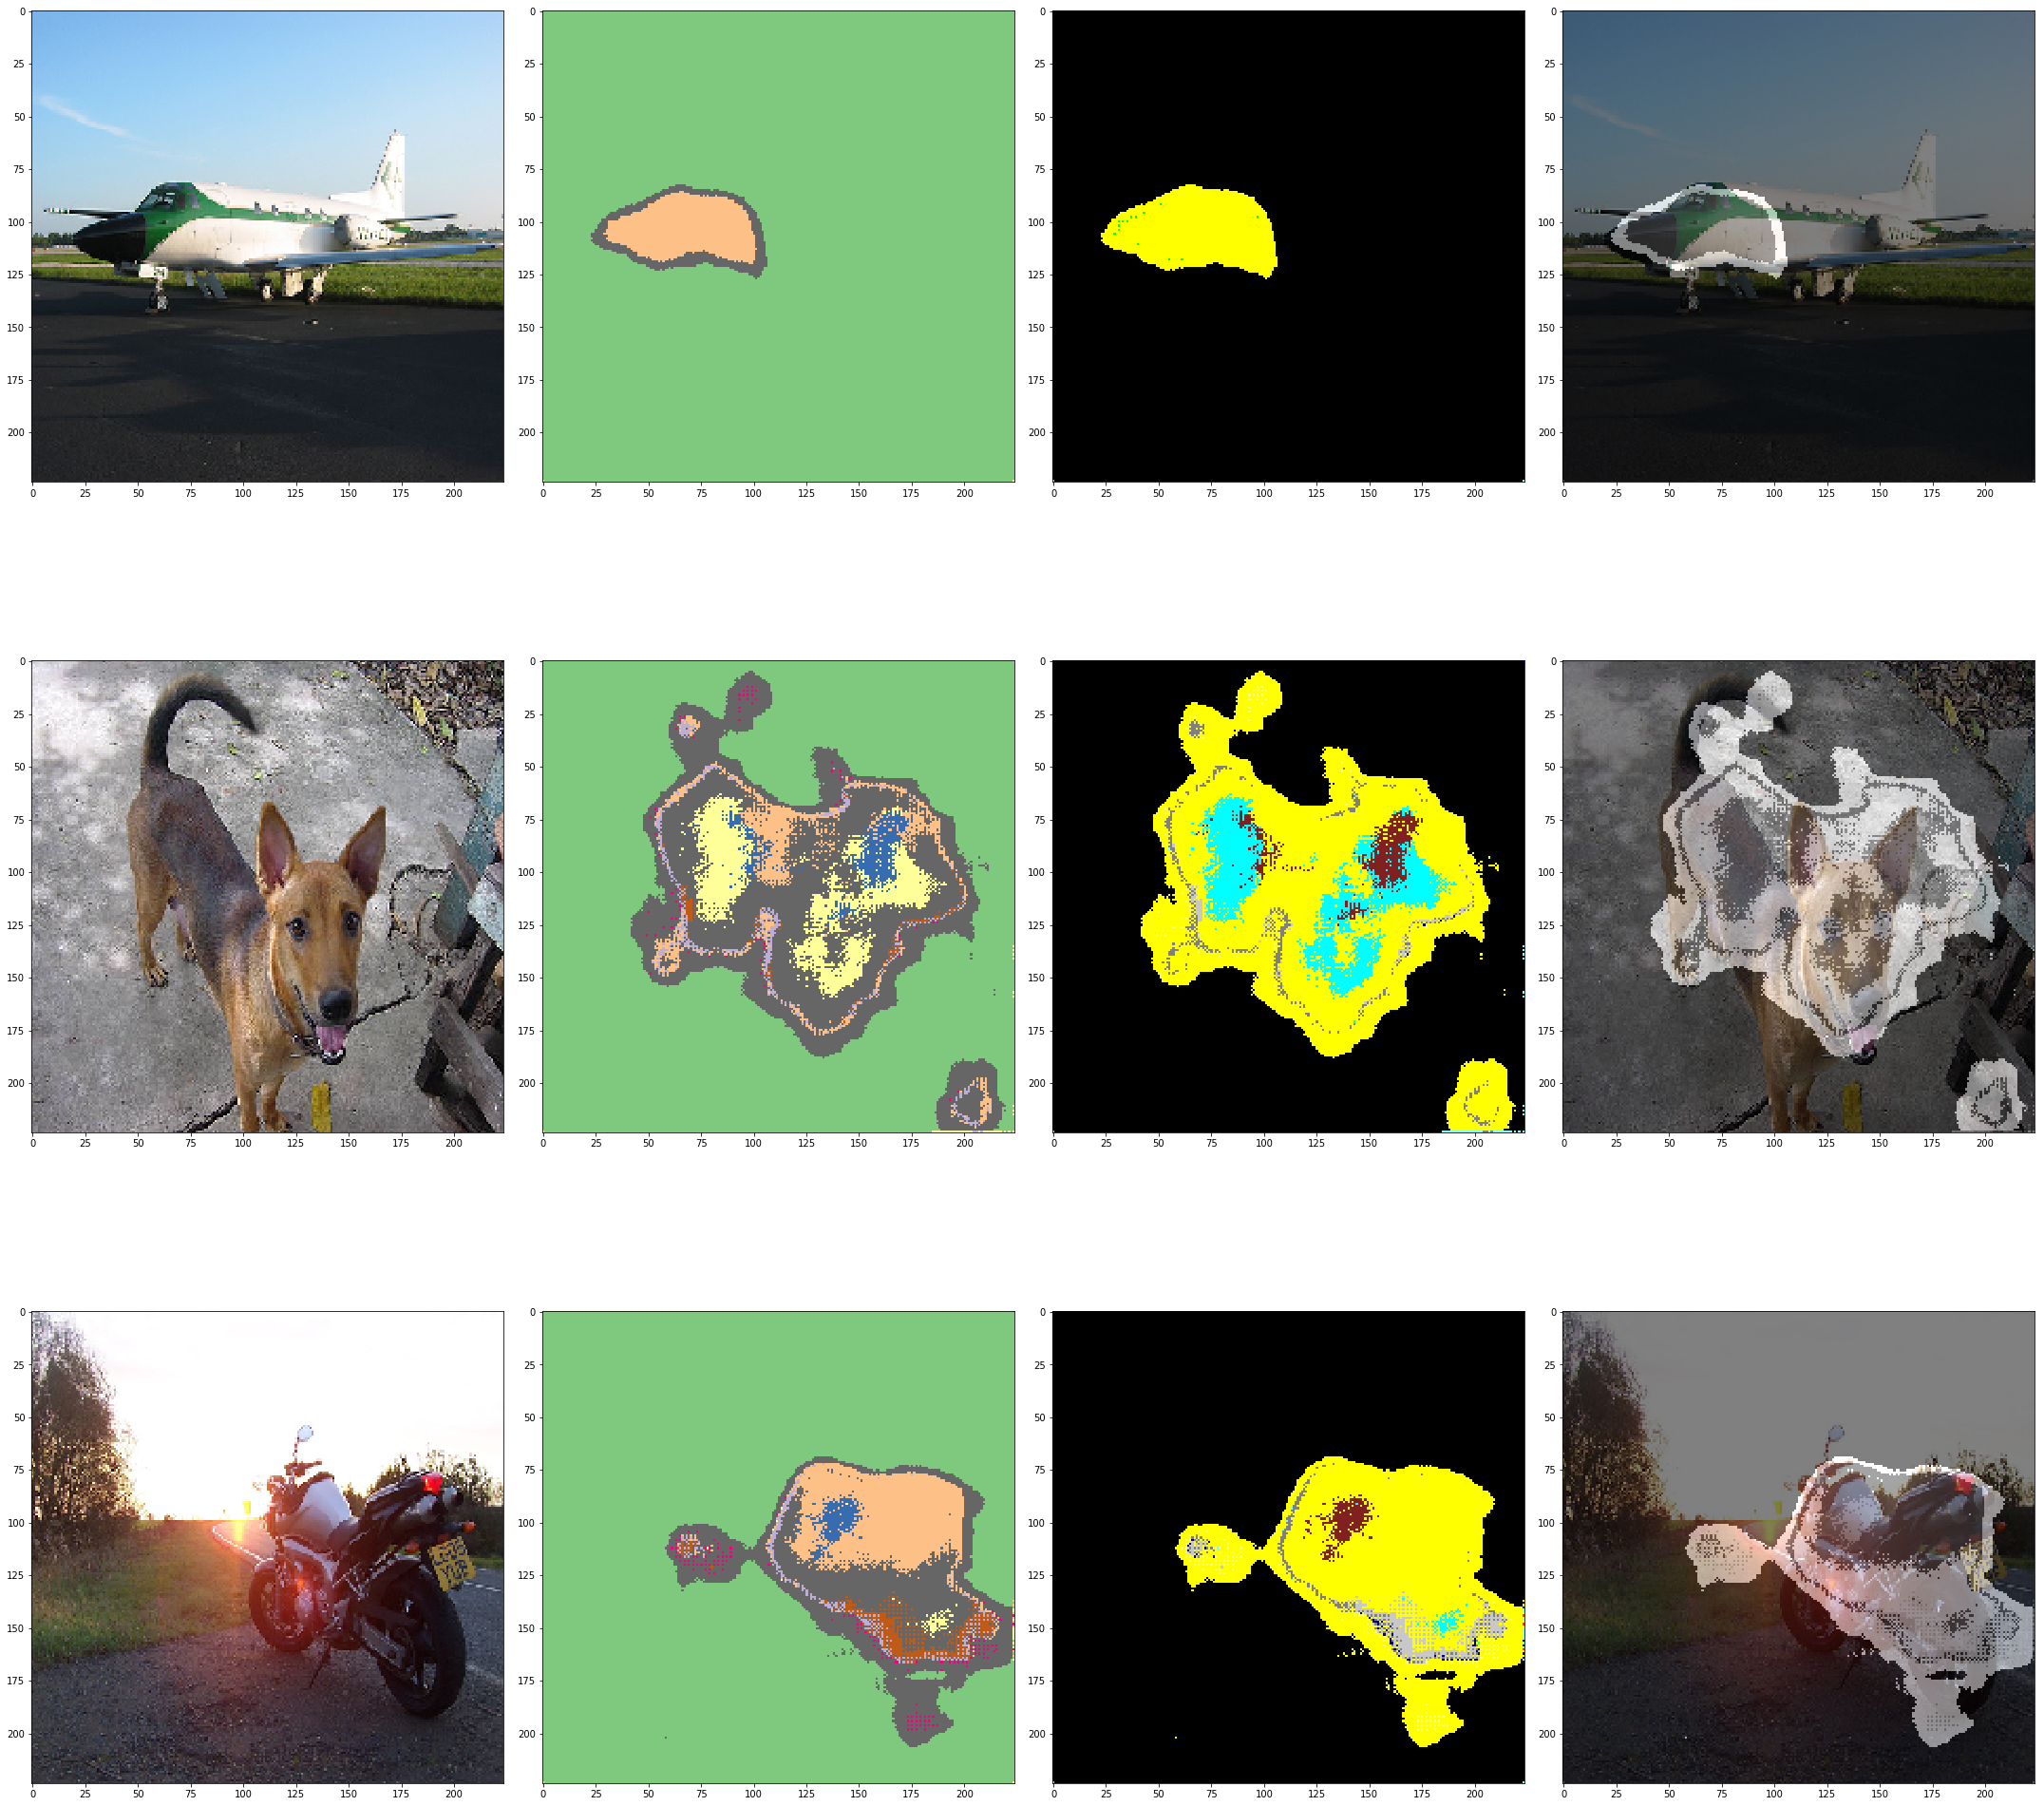

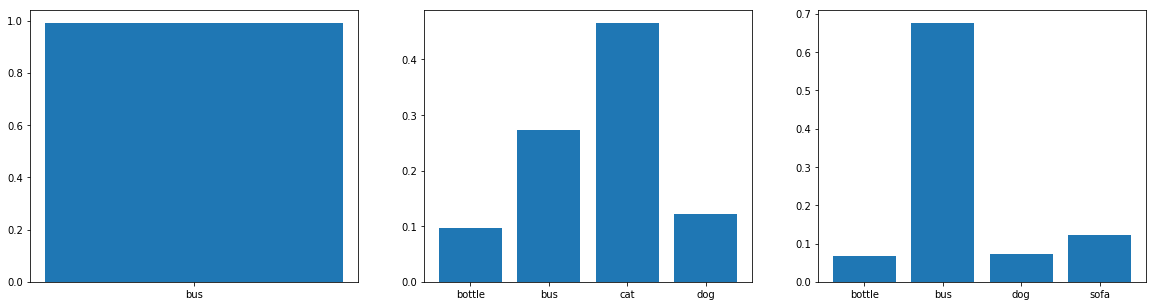

In [6]:
model_path = os.path.join(old_results_path, "model_unregularized", "base") 
model = load_model(model_path)
predict(model)
# plot_loss_and_accuracy(model_path)

# Experiment 3
- Unregularized
- 5 encoding blocks, 5 decoding blocks
- Filters on block 1: 64 --> Filters on block 5: 1024
- Optimizer: Adam 
    - Learning rate 0.00001
    - Decay: 0.9
- Loss: Categorical_Crossentropy

Loading model...
Loaded model from disk
3/3 [==============================] - 3s 863ms/step


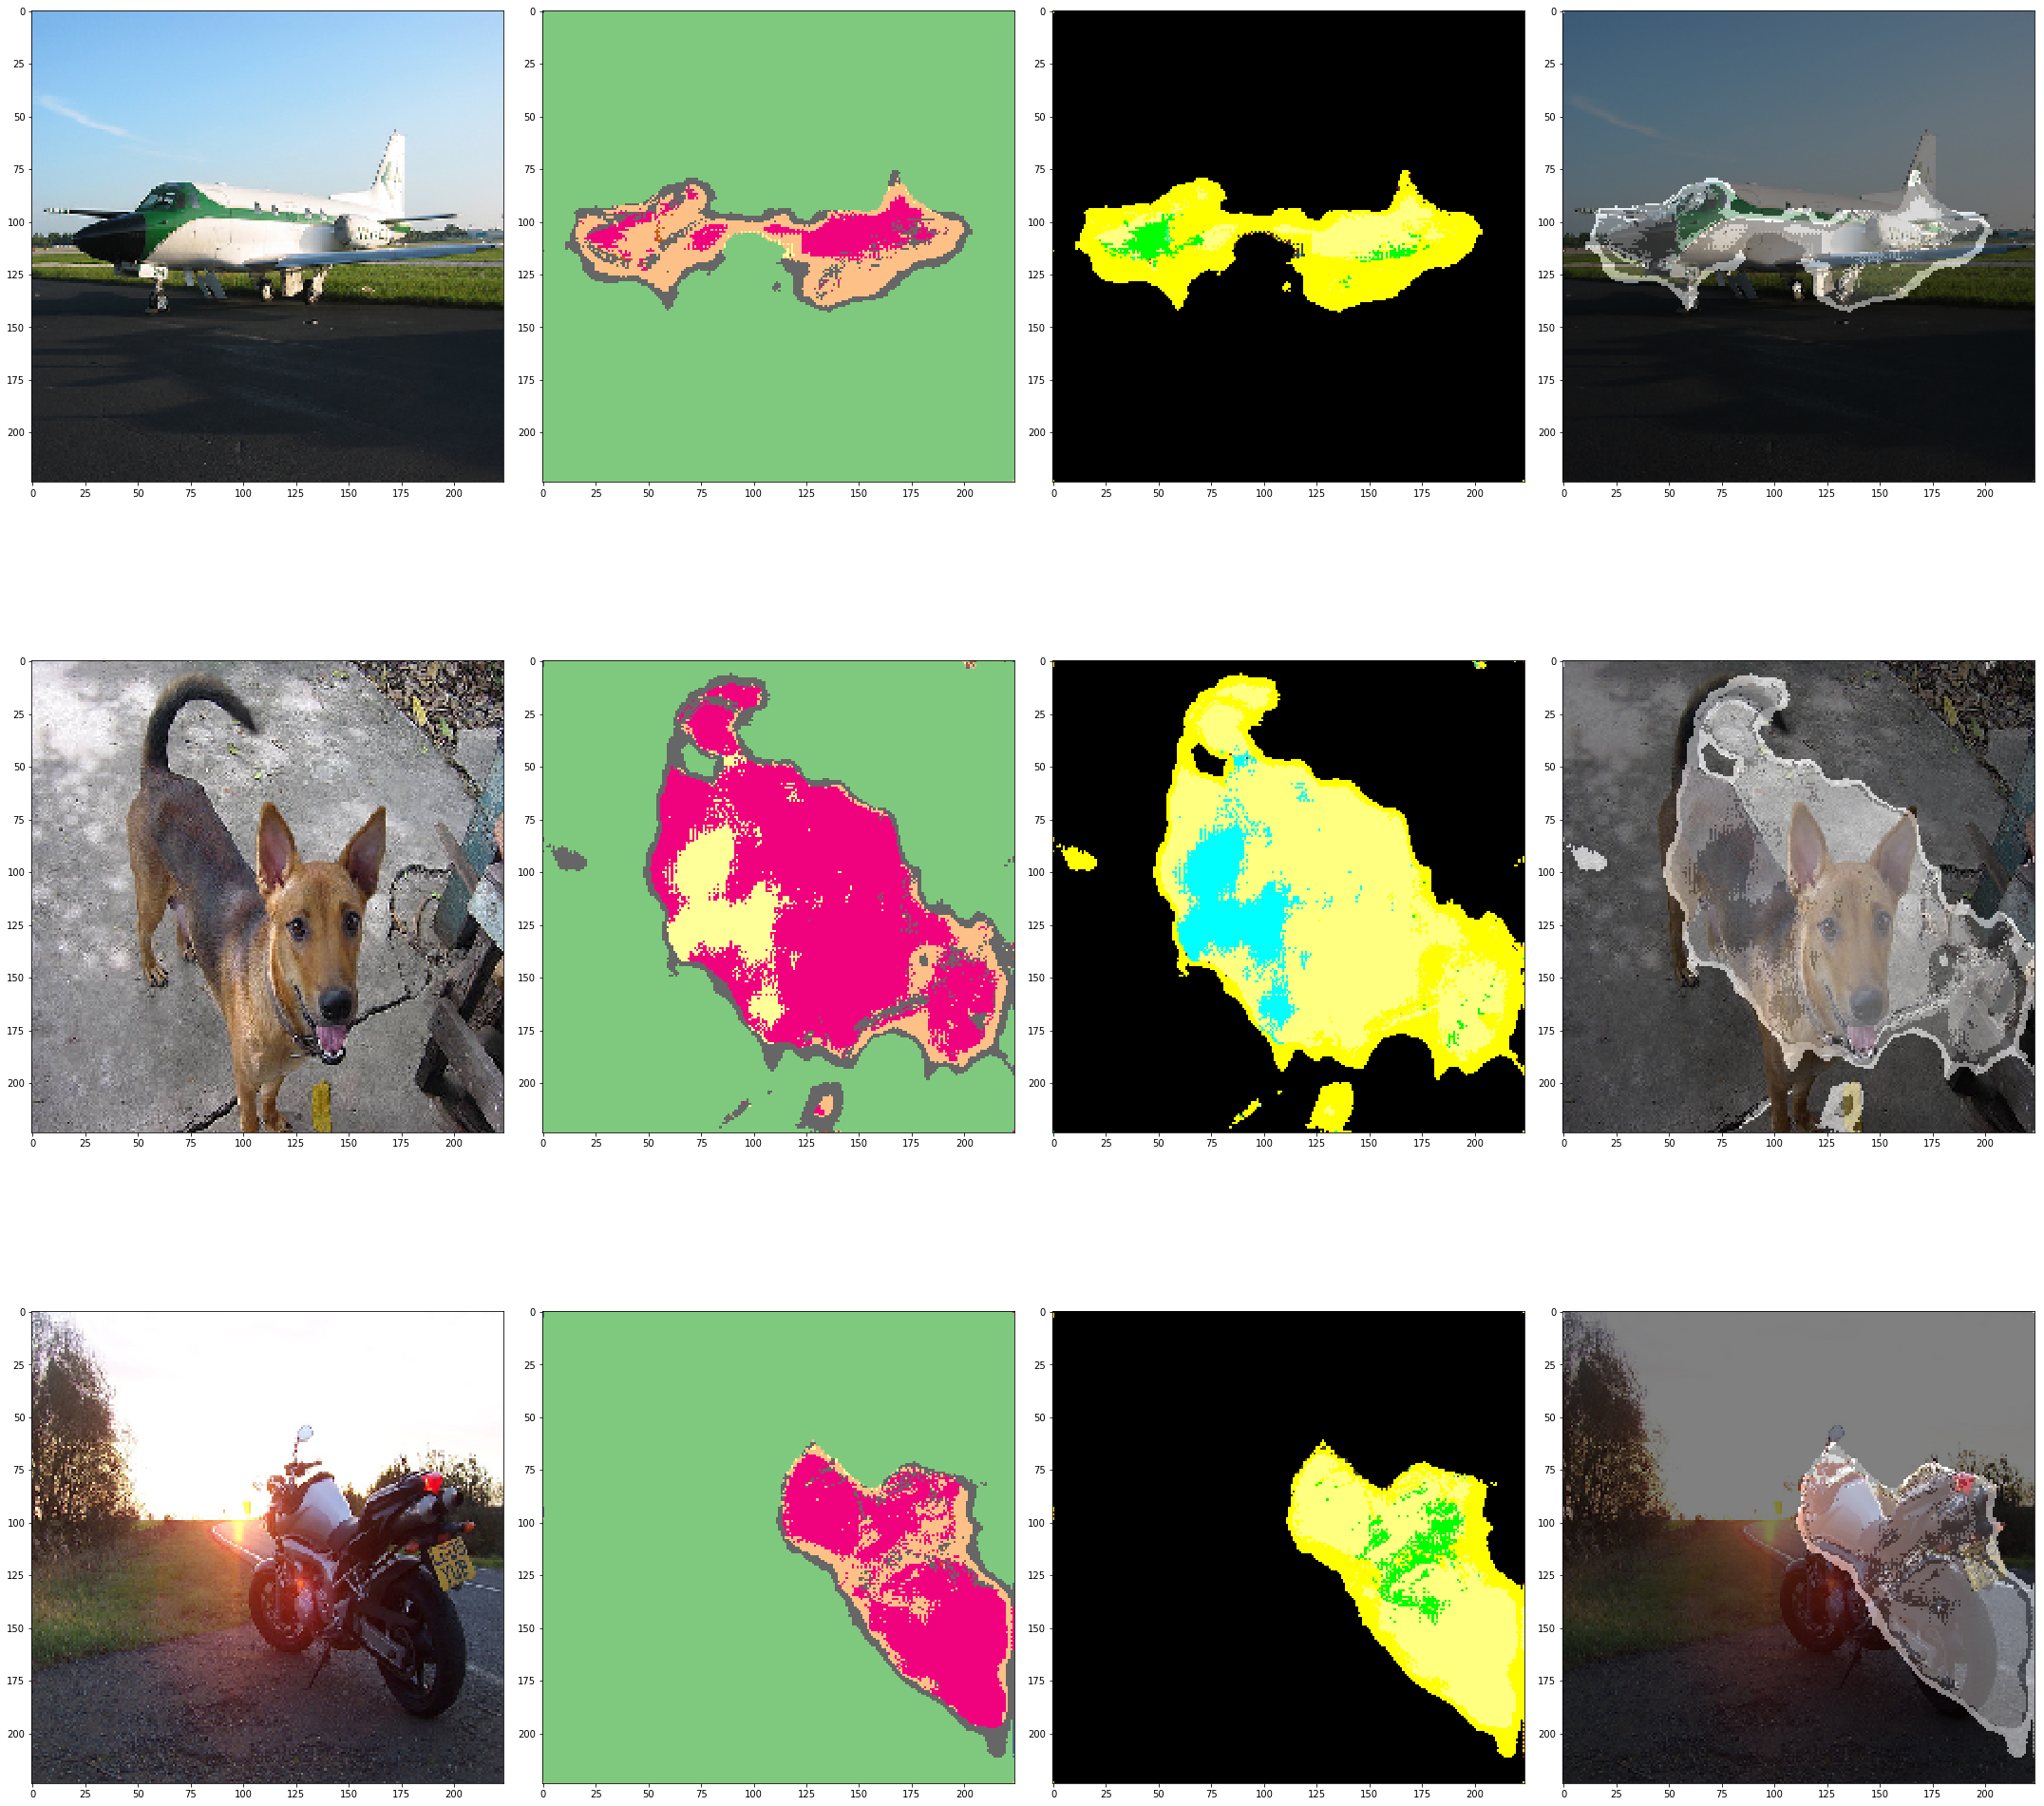

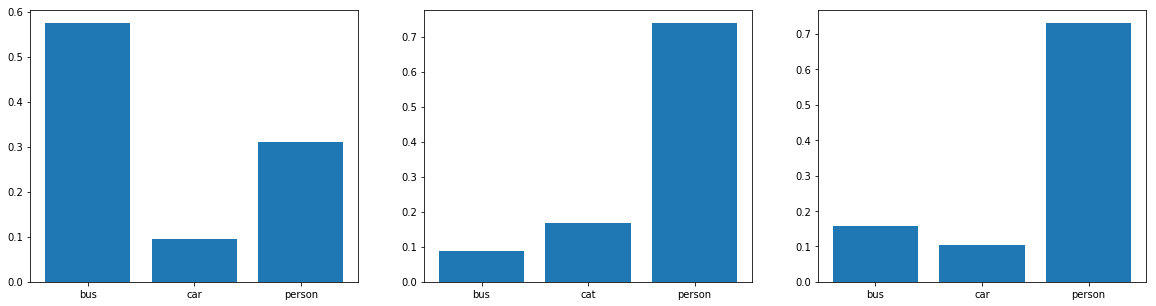

In [7]:
model_path = os.path.join(old_results_path, "model_unregularized", "more_filters") 
model = load_model(model_path)
predict(model)
# plot_loss_and_accuracy(model_path)

# Experiment 4
- regularized
- 5 encoding blocks, 5 decoding blocks
- After every encoding block, we add a dropout layer with dropout rate 0.25
- Filters on block 1: 16 --> Filters on block 5: 256
- Optimizer: Adam 
    - Learning rate 0.00001
    - Decay: 0.9
- Loss: Categorical_Crossentropy

Loading model...
Loaded model from disk
3/3 [==============================] - 1s 495ms/step


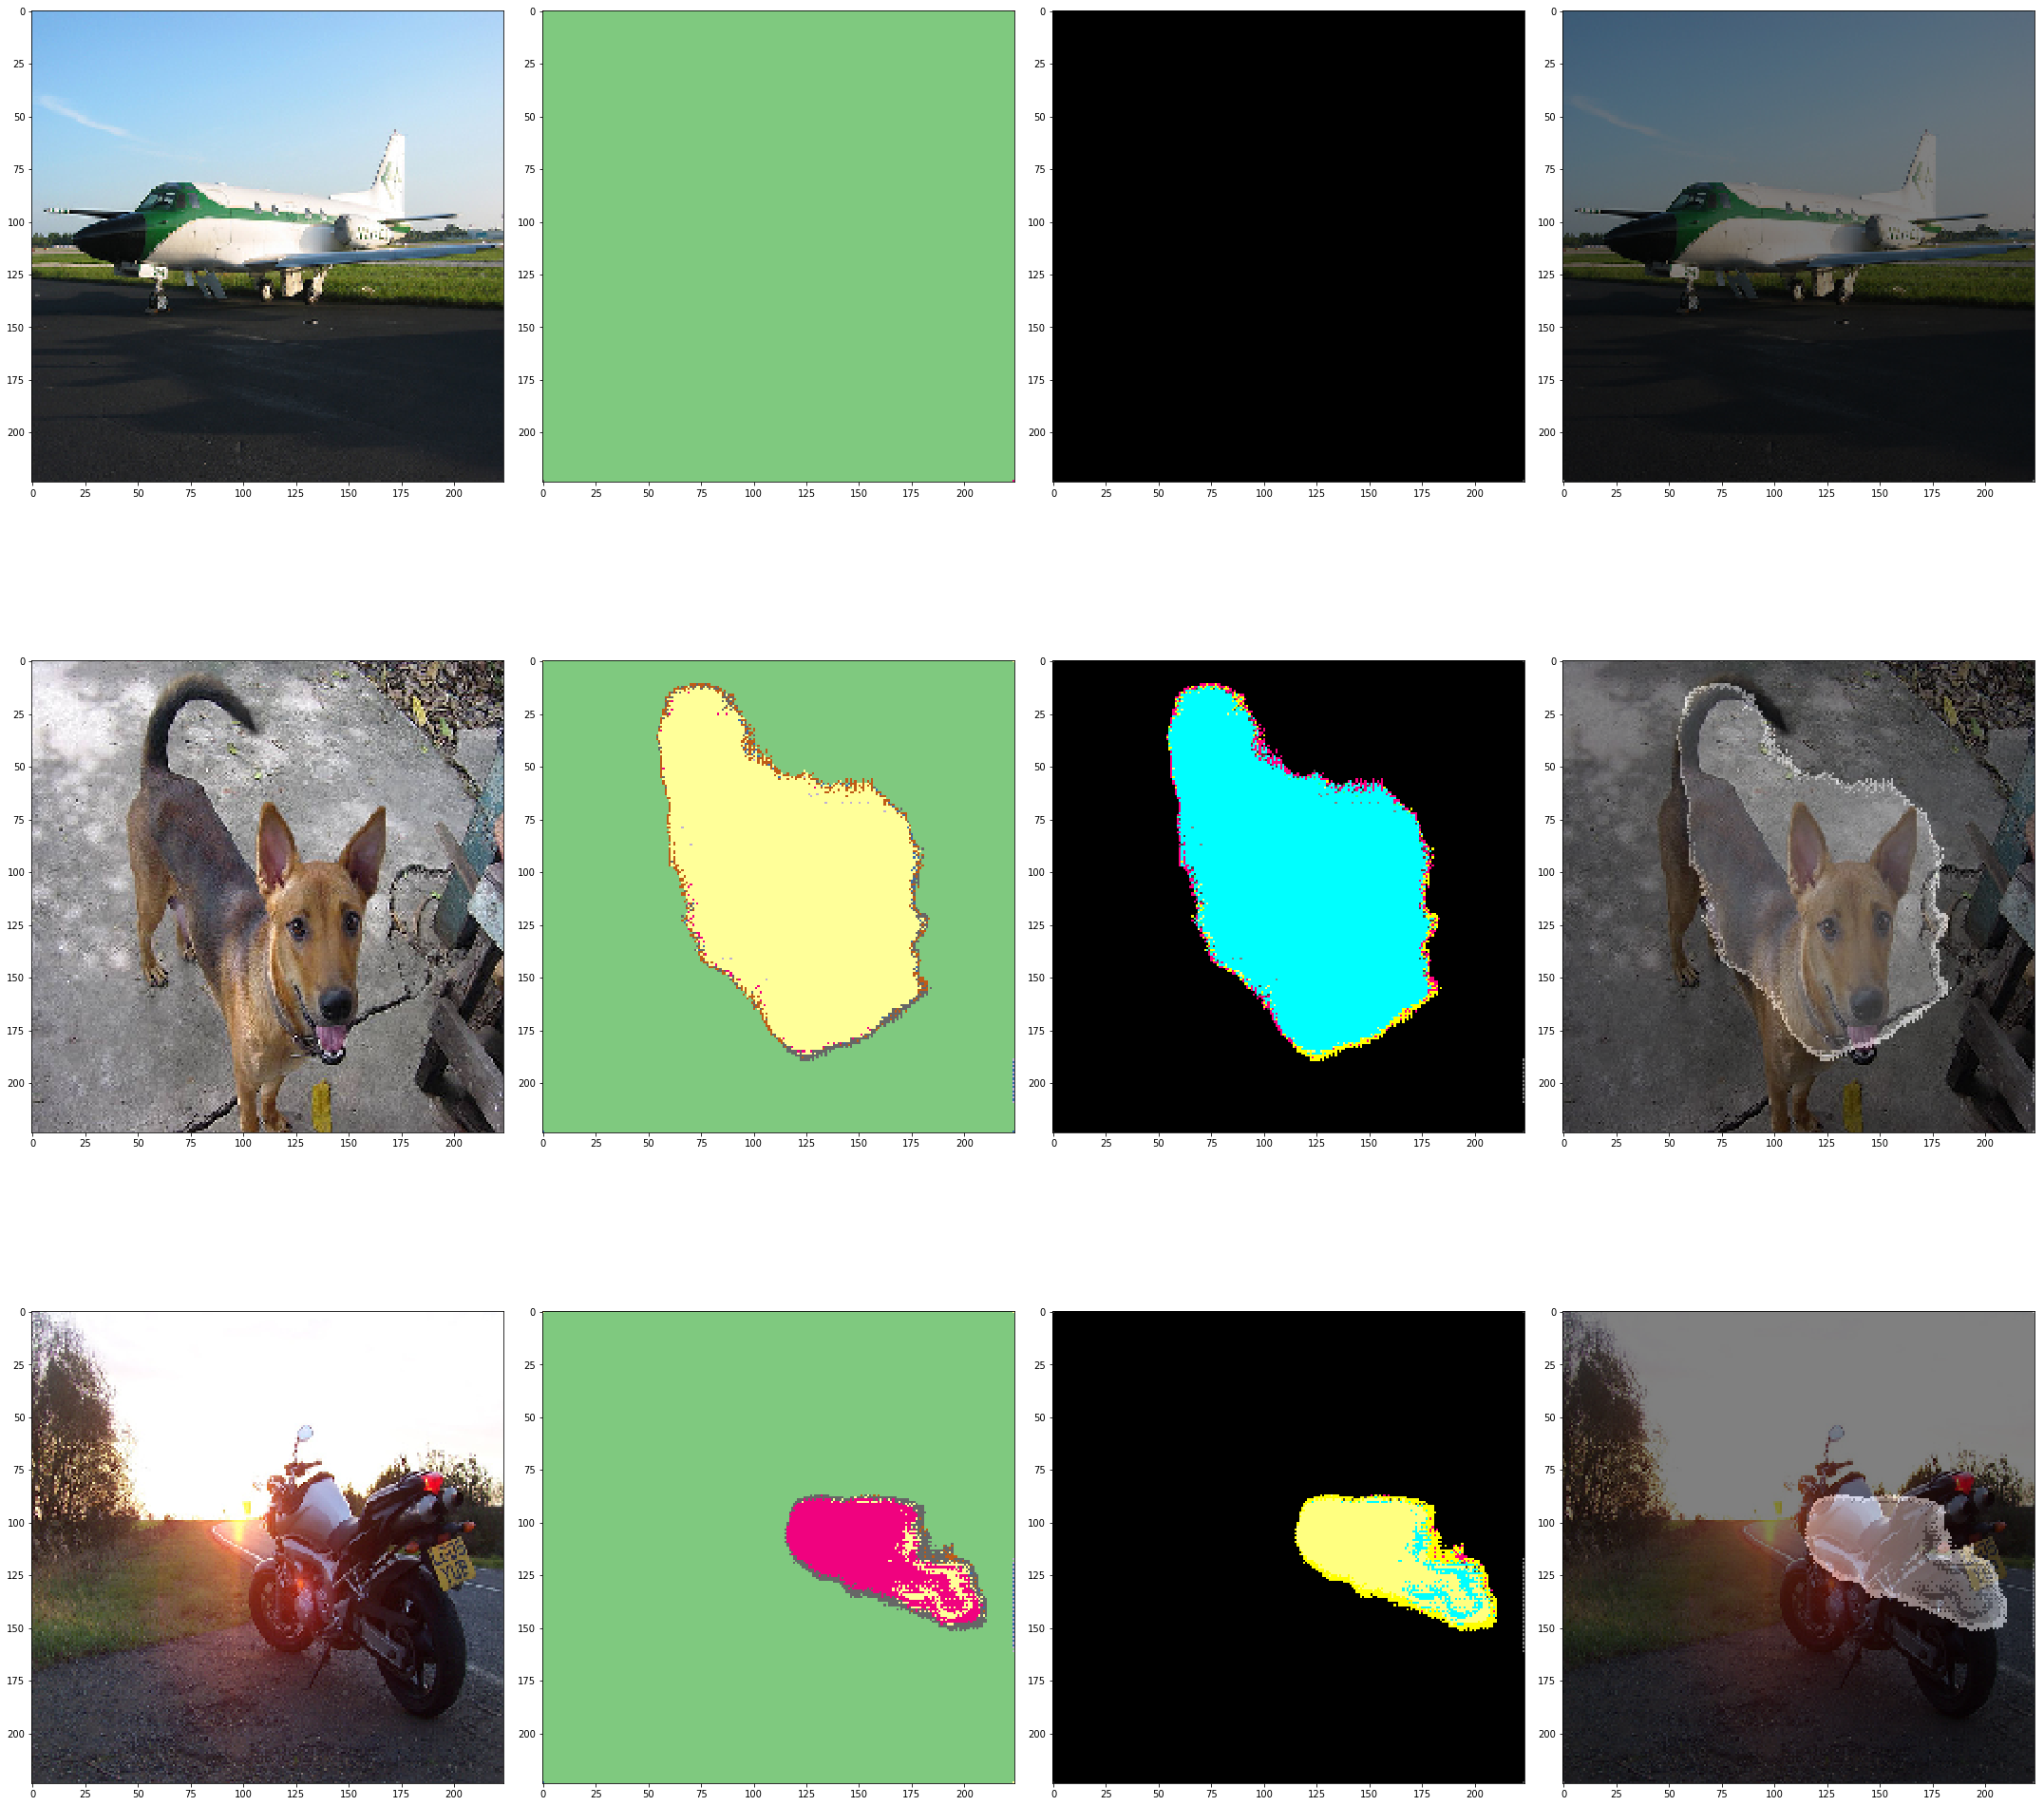

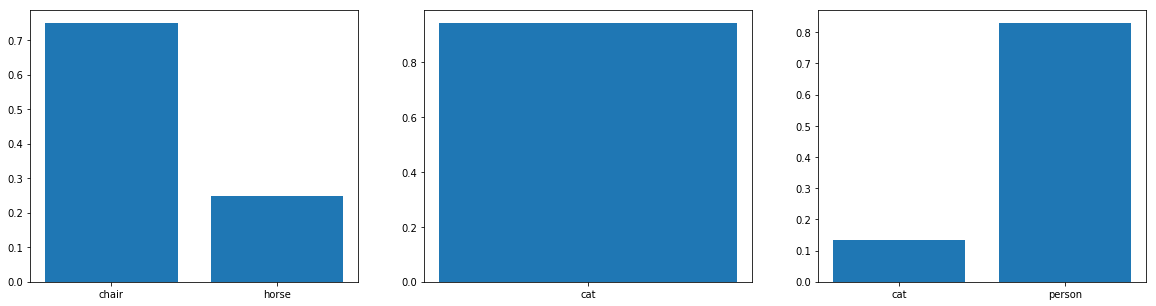

In [8]:
model_path = os.path.join(old_results_path, "model_regularized", "base") 
model = load_model(model_path)
predict(model)
# plot_loss_and_accuracy(model_path)

# Experiment 5
- regularized
- 5 encoding blocks, 5 decoding blocks
- After every encoding and decoding block, we add a dropout layer with dropout rate 0.25
- Filters on block 1: 32 --> Filters on block 5: 512
- Optimizer: Adam 
    - Learning rate 0.00001
    - Decay: 0.9
- Loss: Categorical_Crossentropy

Loading model...
Loaded model from disk
3/3 [==============================] - 1s 383ms/step


/Applications/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide


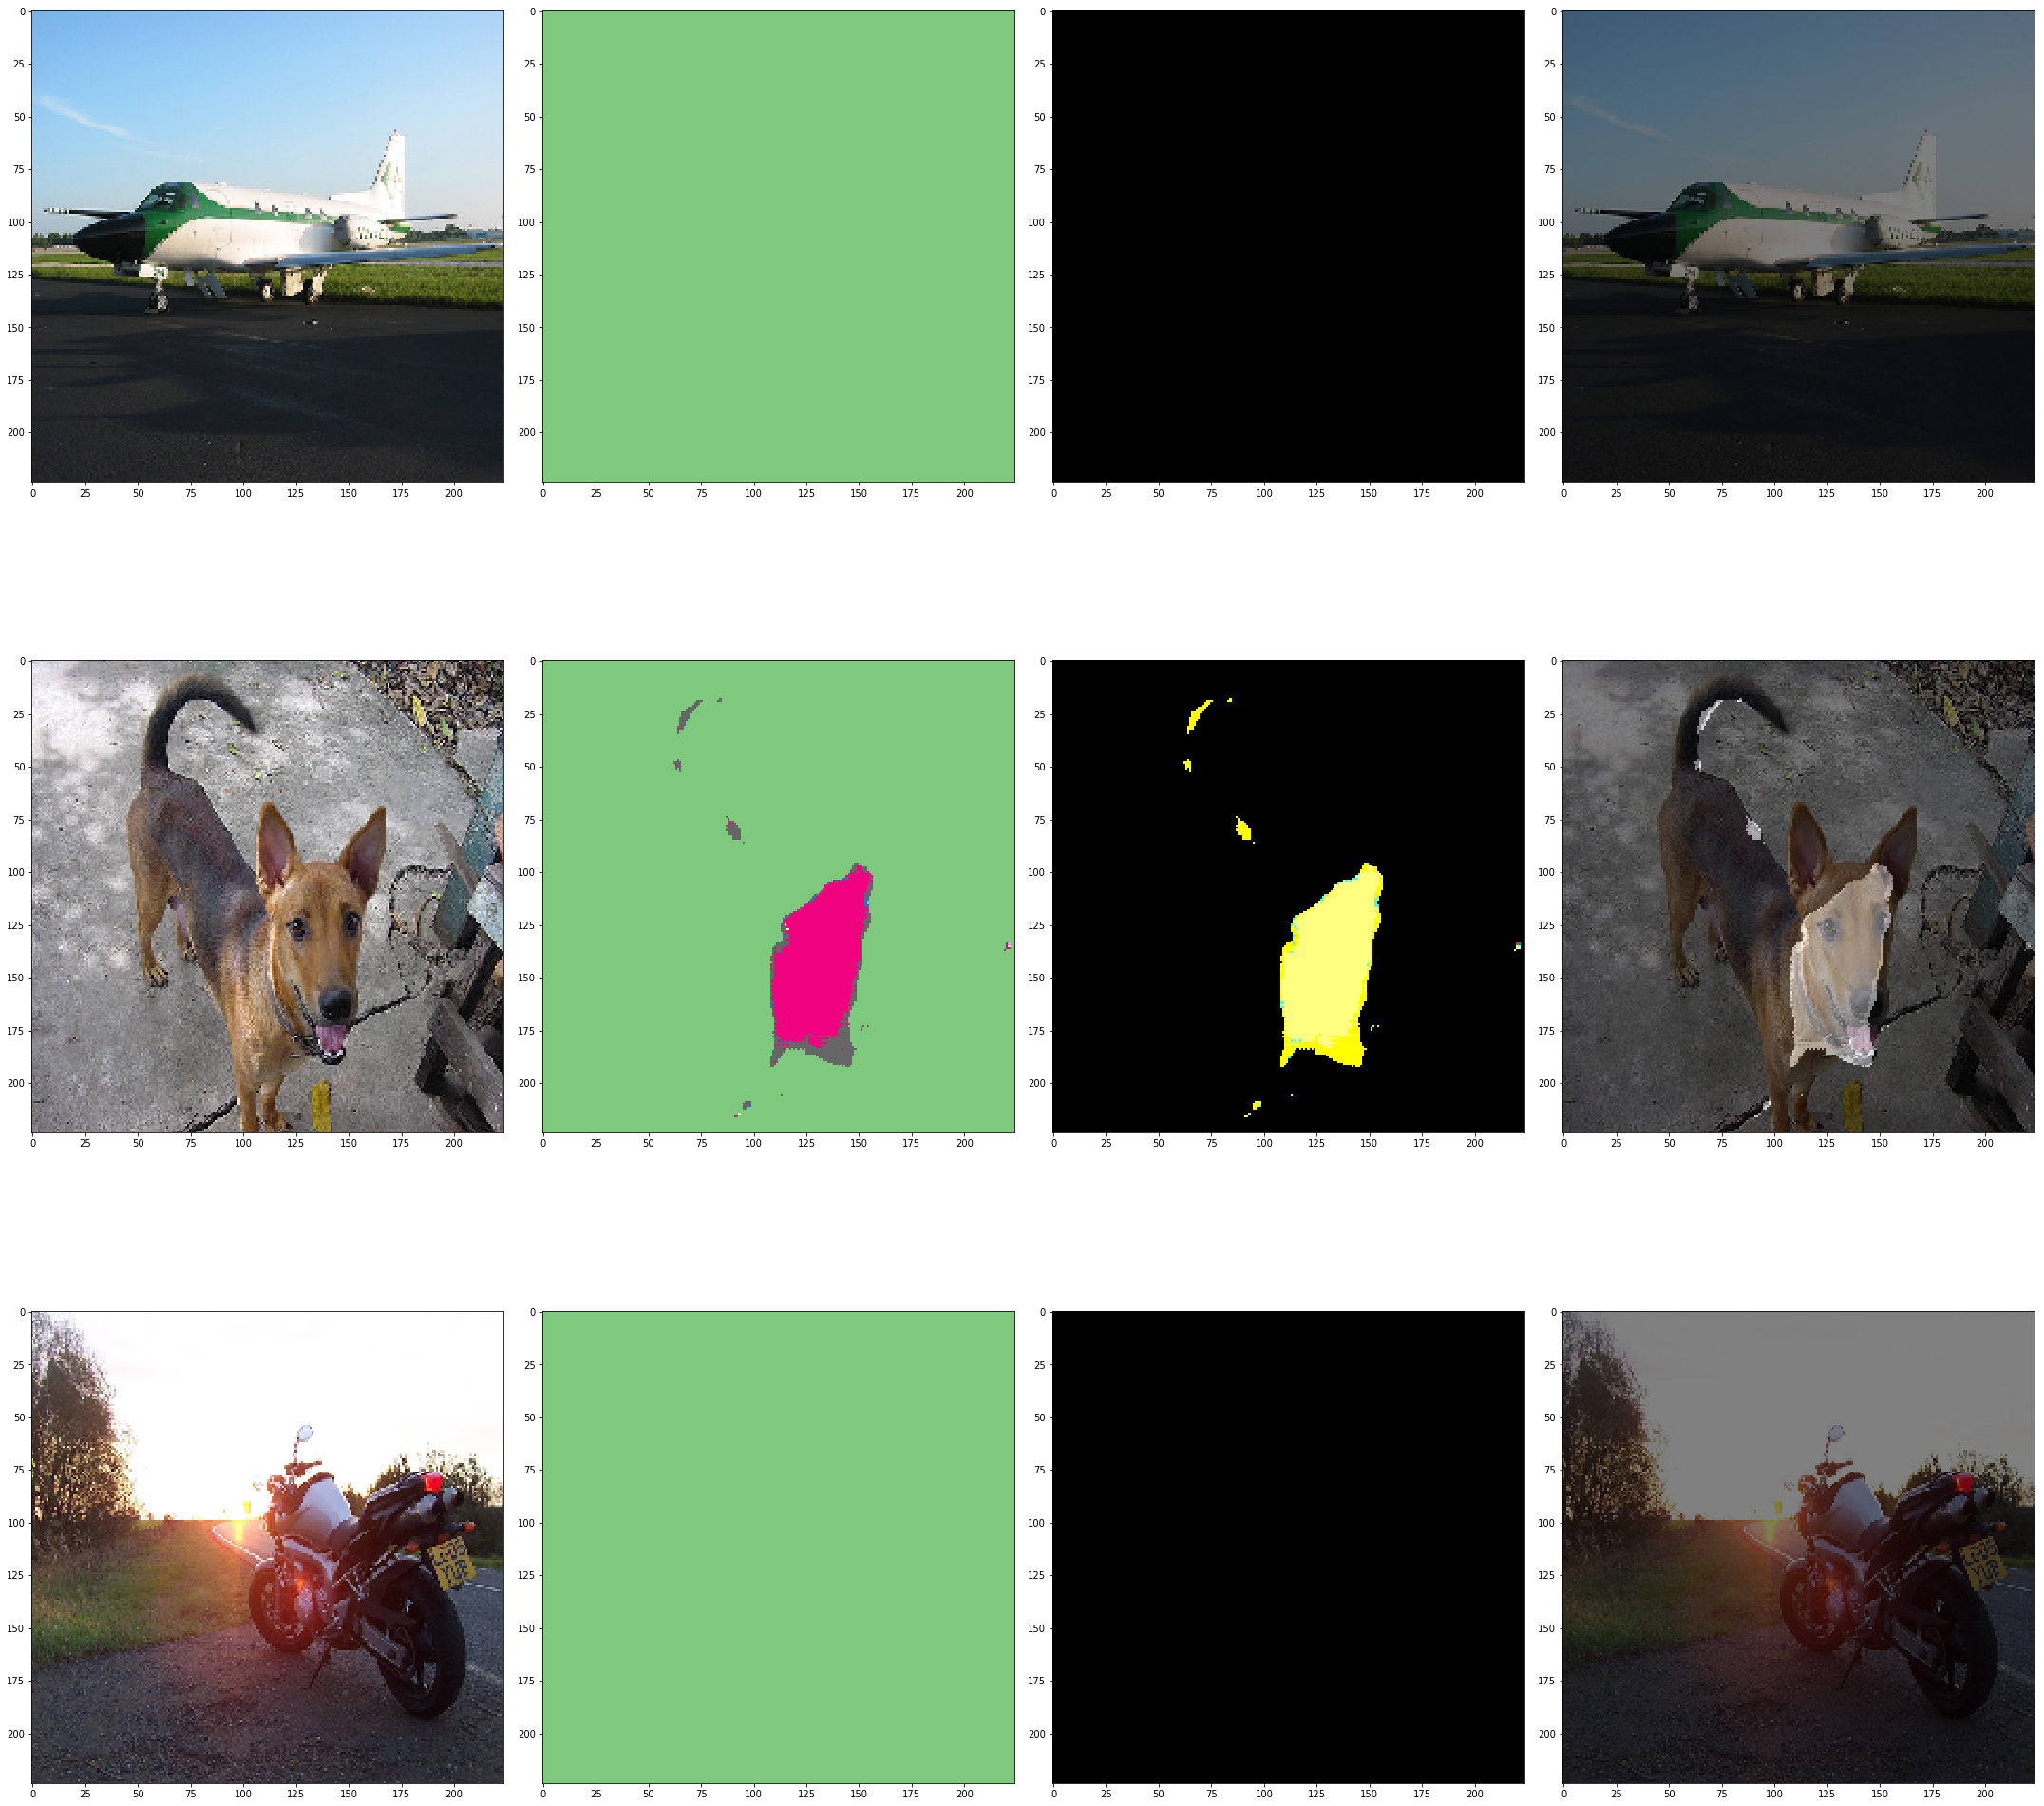

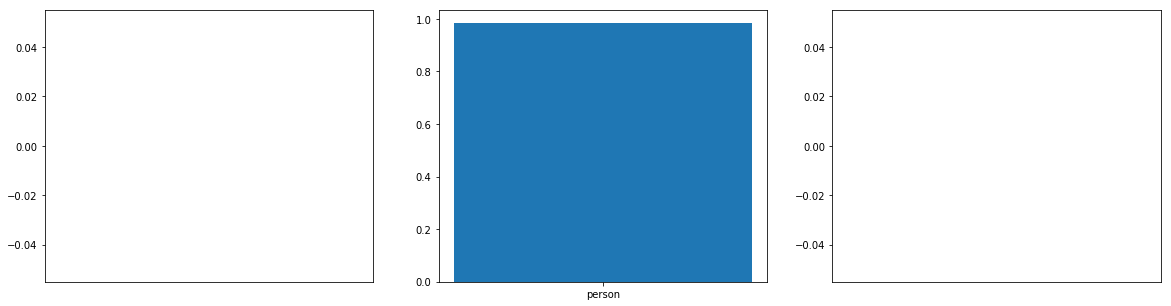

In [9]:
model_path = os.path.join(old_results_path, "model_regularized", "more_filters") 
model = load_model(model_path)
predict(model)
# plot_loss_and_accuracy(model_path)

# EMBEDDINGS
- VGG16 Encoder
- Deconvolutional layers in decoder
- Optimizer: Adam 
    - Learning rate 0.00001
    - Decay: 0.9
- Loss: Categorical_Crossentropy

Loading model...
Loaded model from disk
3/3 [==============================] - 7s 2s/step


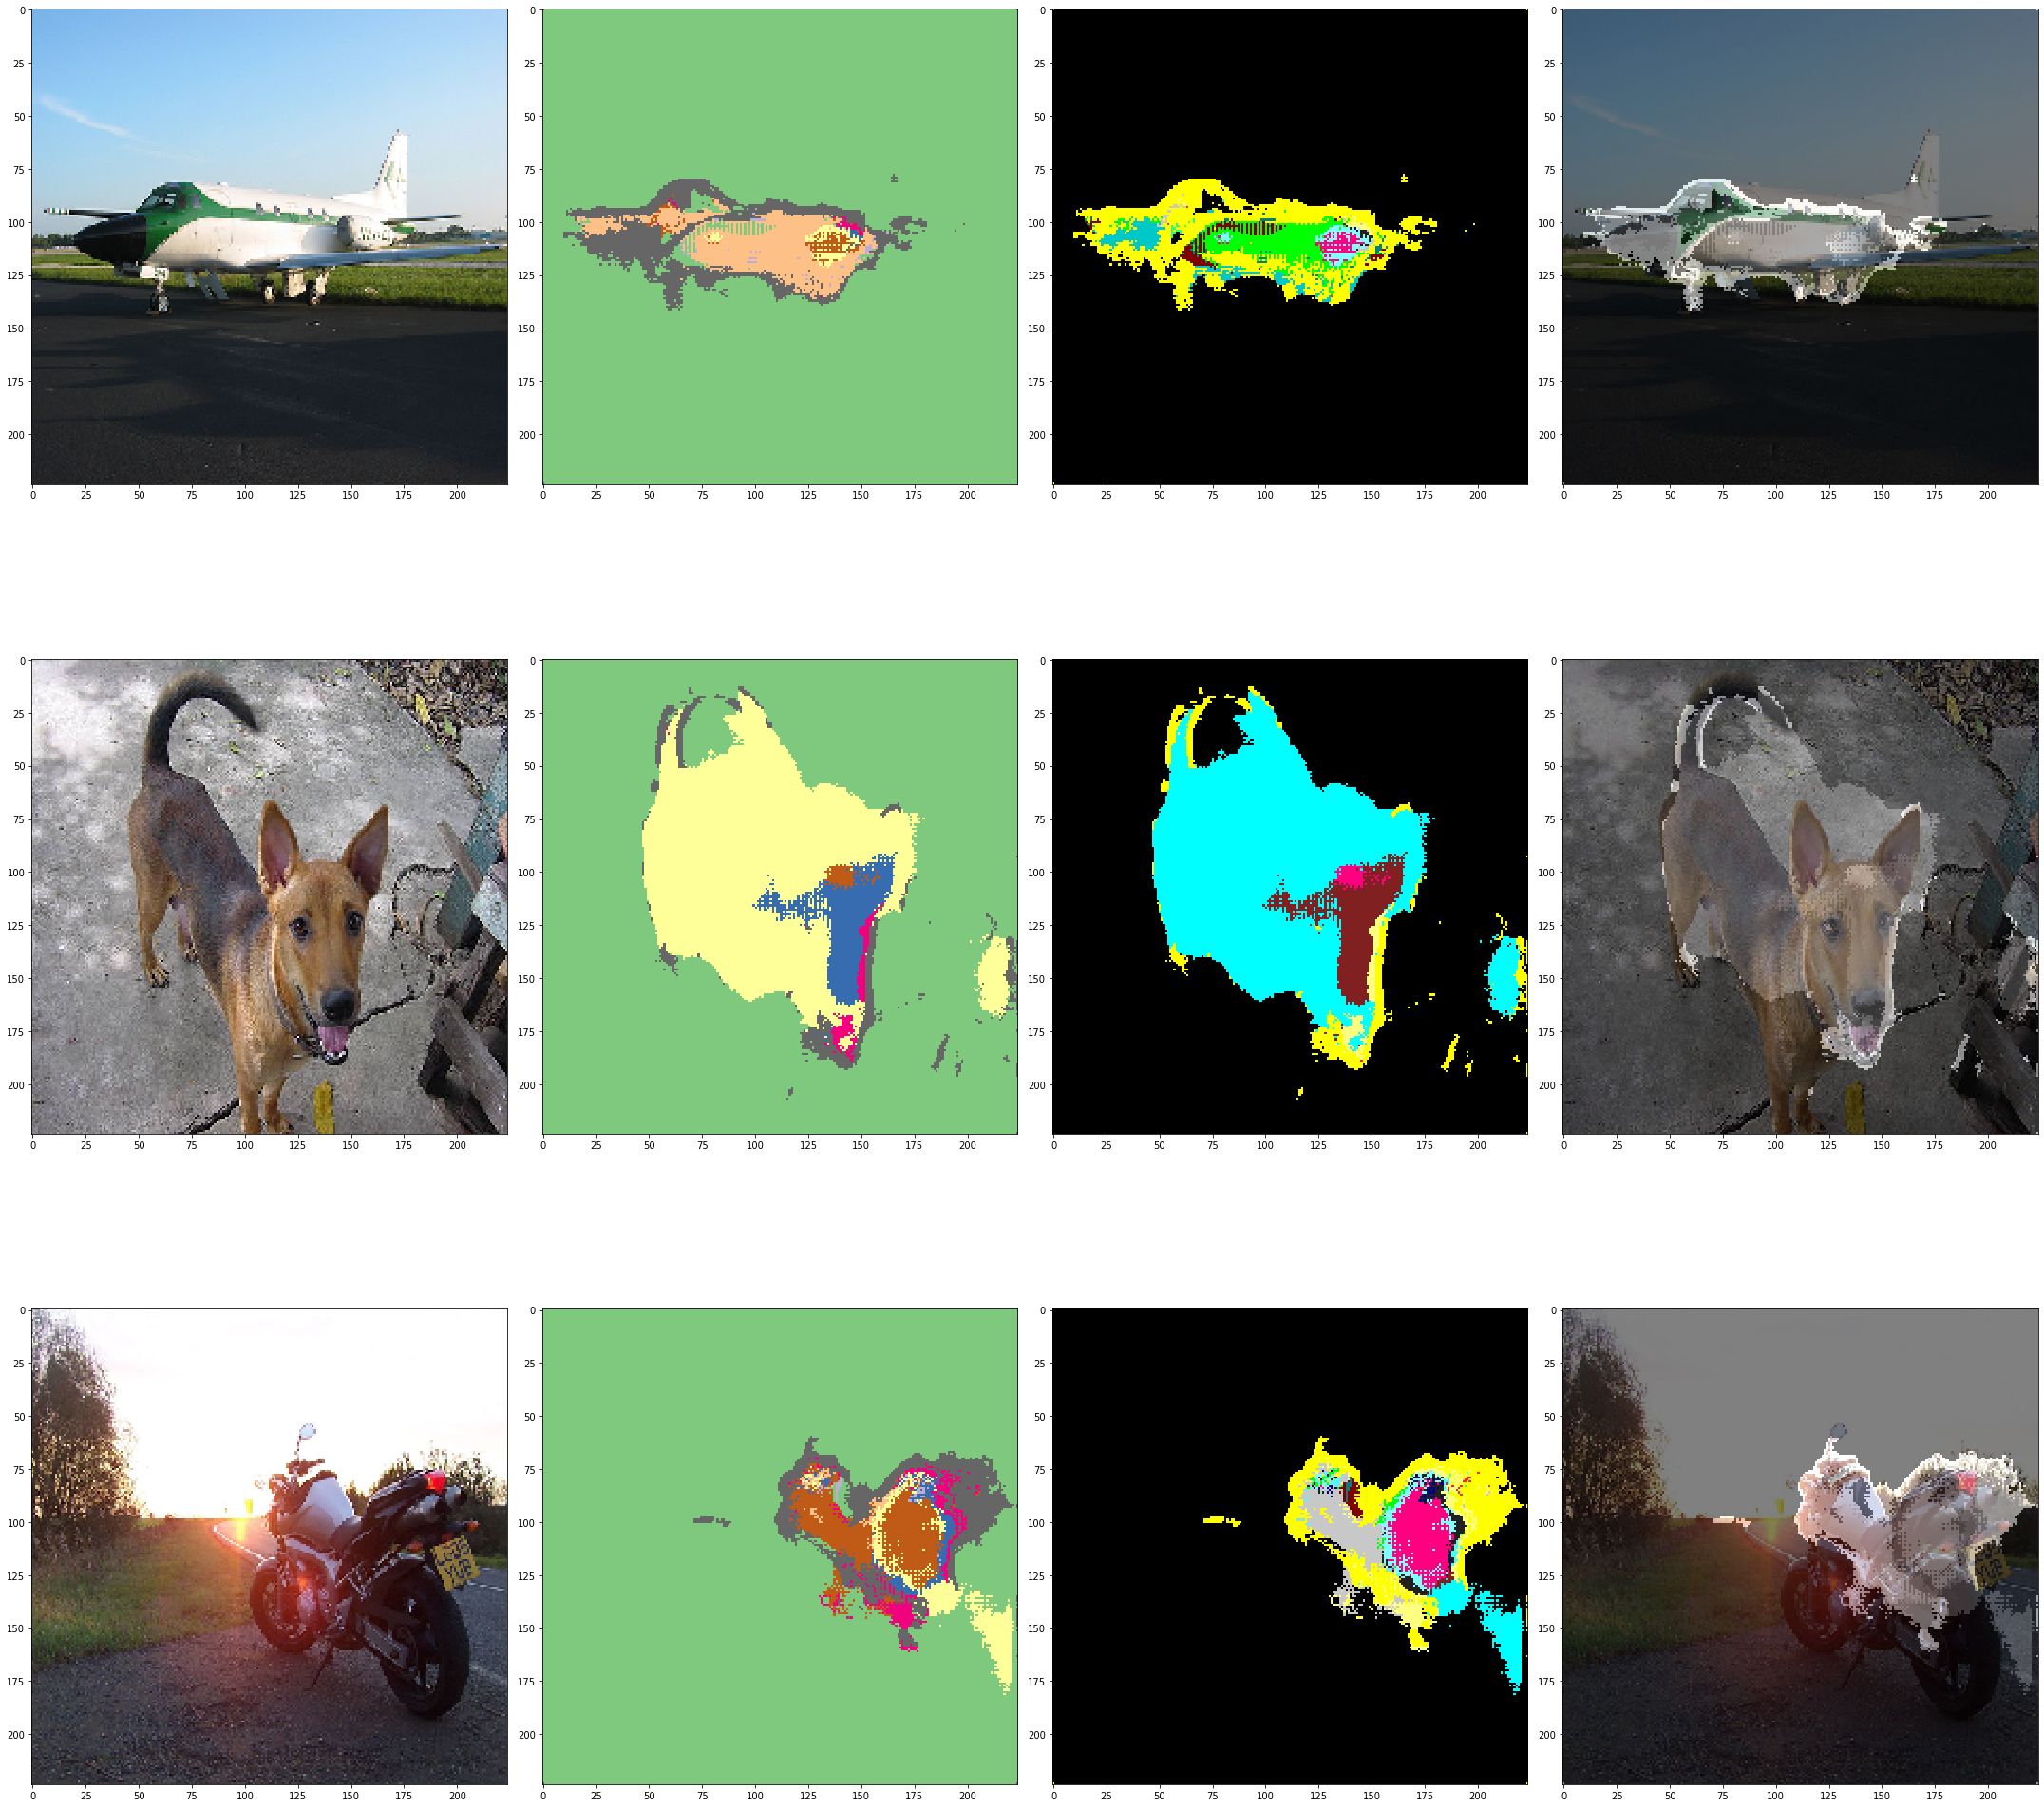

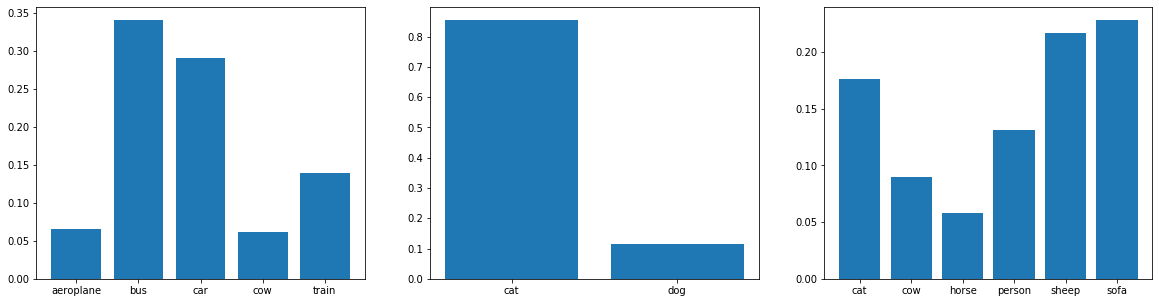

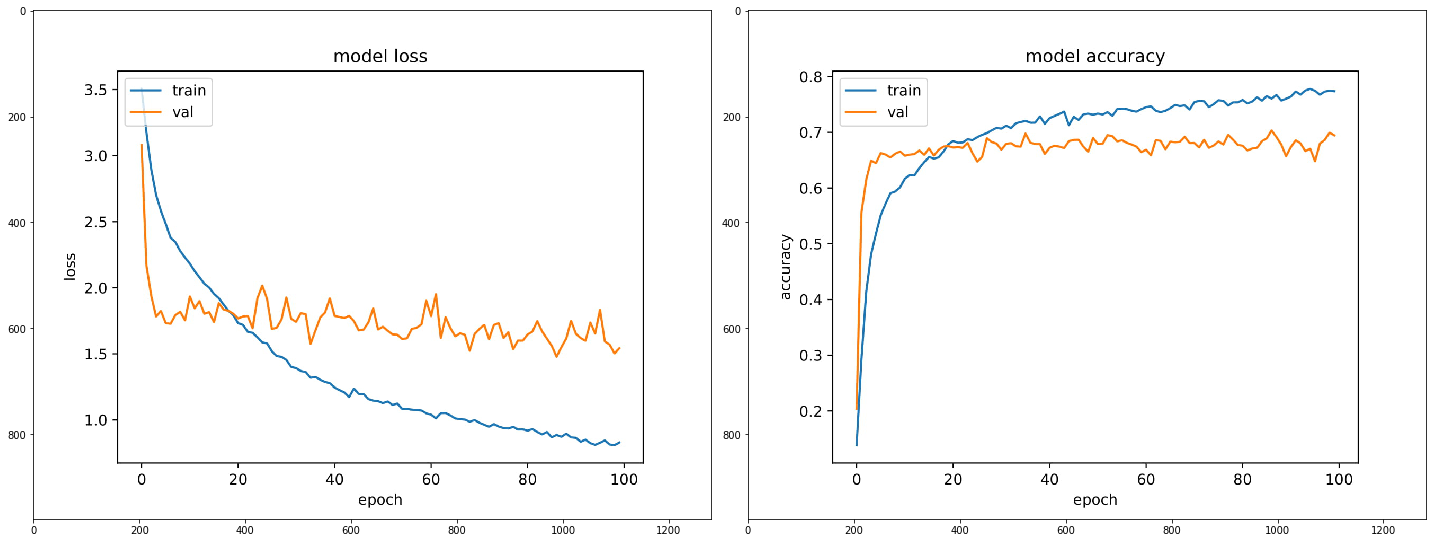

In [5]:
model_path = os.path.join(results_path, "experiment_7", "unknown") 
model = load_model(model_path)
predict(model)
plot_loss_and_accuracy(model_path)